## Introduction
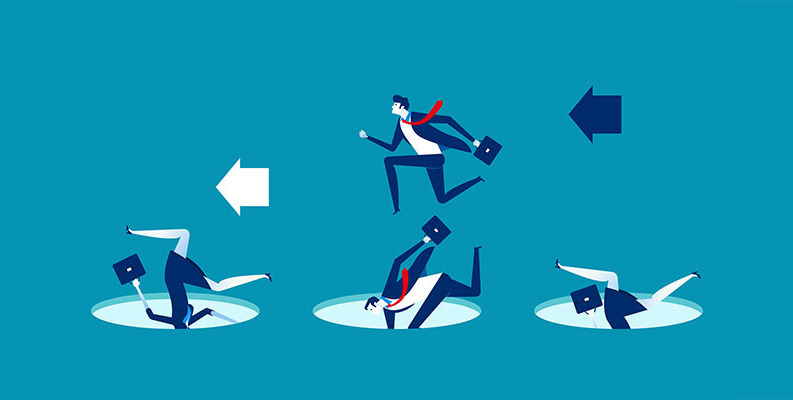

Churn prediction is the process of identifying which consumers are most likely to stop using a service or cancel their subscription. This is a critical factor for many businesses because acquiring new consumers costs more than retaining existing ones.

This project focuses on the analysis and prediction of customer attrition for 'ABC Multinational Bank', a fictional bank, using customer data. The dataset for ABC Multinational Bank indicates which customers have left, stayed, or signed up for their service. Multiple important demographics are included for each customer that can help us identify at-risk customers, pain points, and actions to be taken.

## About dataset

This dataset is for ABC Multinational bank with following columns:

- customer_id, unused variable.
- credit_score, used as input.
- country, used as input.
- gender, used as input.
- age, used as input.
- tenure, used as input.
- balance, used as input.
- products_number, used as input.
- credit_card, used as input.
- active_member, used as input.
- estimated_salary, used as input.
- churn, used as the target. 1 if the client has left the bank during some period or 0 if he/she has not.

Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [2]:
filename = "/kaggle/input/bank-customer-churn-dataset/Bank Customer Churn Prediction.csv"

## Data preparation and cleaning

Loading the dataset as a pandas dataframe

In [3]:
df = pd.read_csv(filename)

Looking at the first 5 records

In [4]:
df.head().style.set_properties(**{"border" : "1px solid"})

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.000000,1,1,1,101348.880000,1
1,15647311,608,Spain,Female,41,1,83807.860000,1,0,1,112542.580000,0
2,15619304,502,France,Female,42,8,159660.800000,3,1,0,113931.570000,1
3,15701354,699,France,Female,39,1,0.000000,2,0,0,93826.630000,0
4,15737888,850,Spain,Female,43,2,125510.820000,1,1,1,79084.100000,0


Looking at 5 random records

In [5]:
df.sample(5).style.set_properties(**{"border" : "1px solid"})

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
8514,15796071,657,Spain,Male,29,7,83889.030000,1,1,0,153059.620000,0
802,15681554,614,Germany,Female,31,7,120599.380000,2,1,1,46163.440000,0
1424,15596671,603,Spain,Female,42,8,91611.120000,1,0,0,144675.300000,1
2975,15774179,487,France,Male,37,6,0.000000,2,1,1,126477.410000,0
2891,15774224,613,Germany,Female,30,5,131563.880000,2,1,0,170638.980000,0


Looking at some general information regarding the dataframe

In [6]:
df.shape

(10000, 12)

In [7]:
df.columns

Index(['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure',
       'balance', 'products_number', 'credit_card', 'active_member',
       'estimated_salary', 'churn'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [9]:
df.describe().T.style.set_properties(**{"border" : "1px solid"})

,count,mean,std,min,25%,50%,75%,max
customer_id,10000.000000,15690940.569400,71936.186123,15565701.000000,15628528.250000,15690738.000000,15753233.750000,15815690.000000
credit_score,10000.000000,650.528800,96.653299,350.000000,584.000000,652.000000,718.000000,850.000000
age,10000.000000,38.921800,10.487806,18.000000,32.000000,37.000000,44.000000,92.000000
tenure,10000.000000,5.012800,2.892174,0.000000,3.000000,5.000000,7.000000,10.000000
balance,10000.000000,76485.889288,62397.405202,0.000000,0.000000,97198.540000,127644.240000,250898.090000
products_number,10000.000000,1.530200,0.581654,1.000000,1.000000,1.000000,2.000000,4.000000
credit_card,10000.000000,0.705500,0.455840,0.000000,0.000000,1.000000,1.000000,1.000000
active_member,10000.000000,0.515100,0.499797,0.000000,0.000000,1.000000,1.000000,1.000000
estimated_salary,10000.000000,100090.239881,57510.492818,11.580000,51002.110000,100193.915000,149388.247500,199992.480000
churn,10000.000000,0.203700,0.402769,0.000000,0.000000,0.000000,0.000000,1.000000


In [10]:
df.nunique()

customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64

Checking for missing values

In [11]:
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

There are no missing values

Checking for duplicates

In [12]:
df.duplicated().sum()

0

There are no duplicates


Checking for data imbalance

In [13]:
df['churn'].value_counts()

churn
0    7963
1    2037
Name: count, dtype: int64

Data is highly imbalanced

Creating a copy of the base data for manipulation and processing

In [14]:
df_cp = df.copy()

Removing 'customer_id' since it is not required

In [15]:
df_cp = df_cp.drop('customer_id',axis=1)
df_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  churn             10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


## Exploratory data analysis and visualization

Analyzing the correlation heatmap

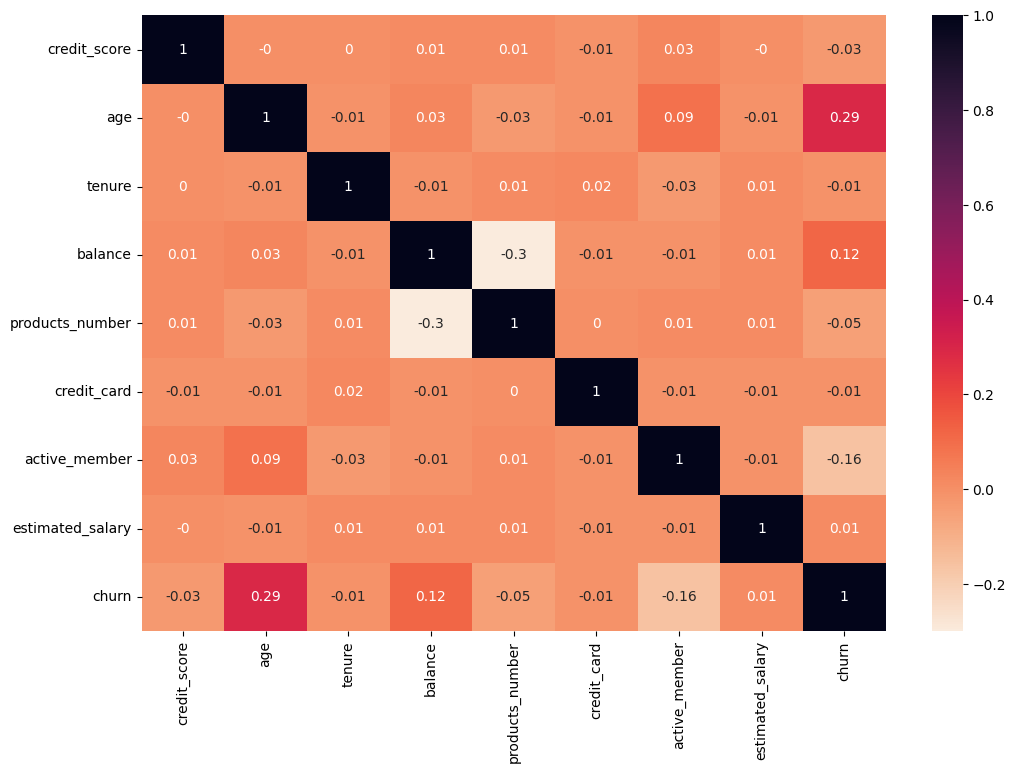

In [16]:
c_map=sns.color_palette("rocket_r", as_cmap=True)
correlation = df_cp.corr(numeric_only=True).round(2)
plt.figure(figsize = (12,8))
sns.heatmap(correlation, annot = True, cmap = c_map)
plt.show()

In [17]:
abs(correlation['churn']).sort_values(ascending=False)

churn               1.00
age                 0.29
active_member       0.16
balance             0.12
products_number     0.05
credit_score        0.03
tenure              0.01
credit_card         0.01
estimated_salary    0.01
Name: churn, dtype: float64

'age', 'active_member', 'balance' show a relatively stronger correlation with the outcome of churn

Plotting a pie chart showing the percentage of churned and retained customers

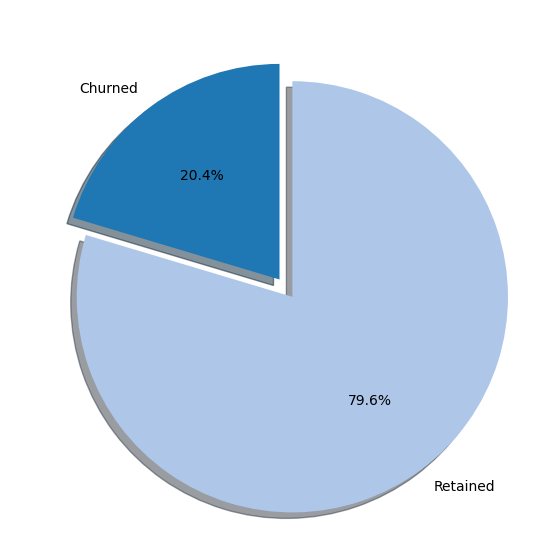

In [18]:
colors=sns.color_palette("tab20")
labels = 'Churned', 'Retained'
sizes = [df_cp.churn[df_cp['churn']==1].count(), df_cp.churn[df_cp['churn']==0].count()]
explode = (0, 0.1)
plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, textprops={'fontsize': 10}, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors)
plt.show()

Analyzing the distribution of numerical features

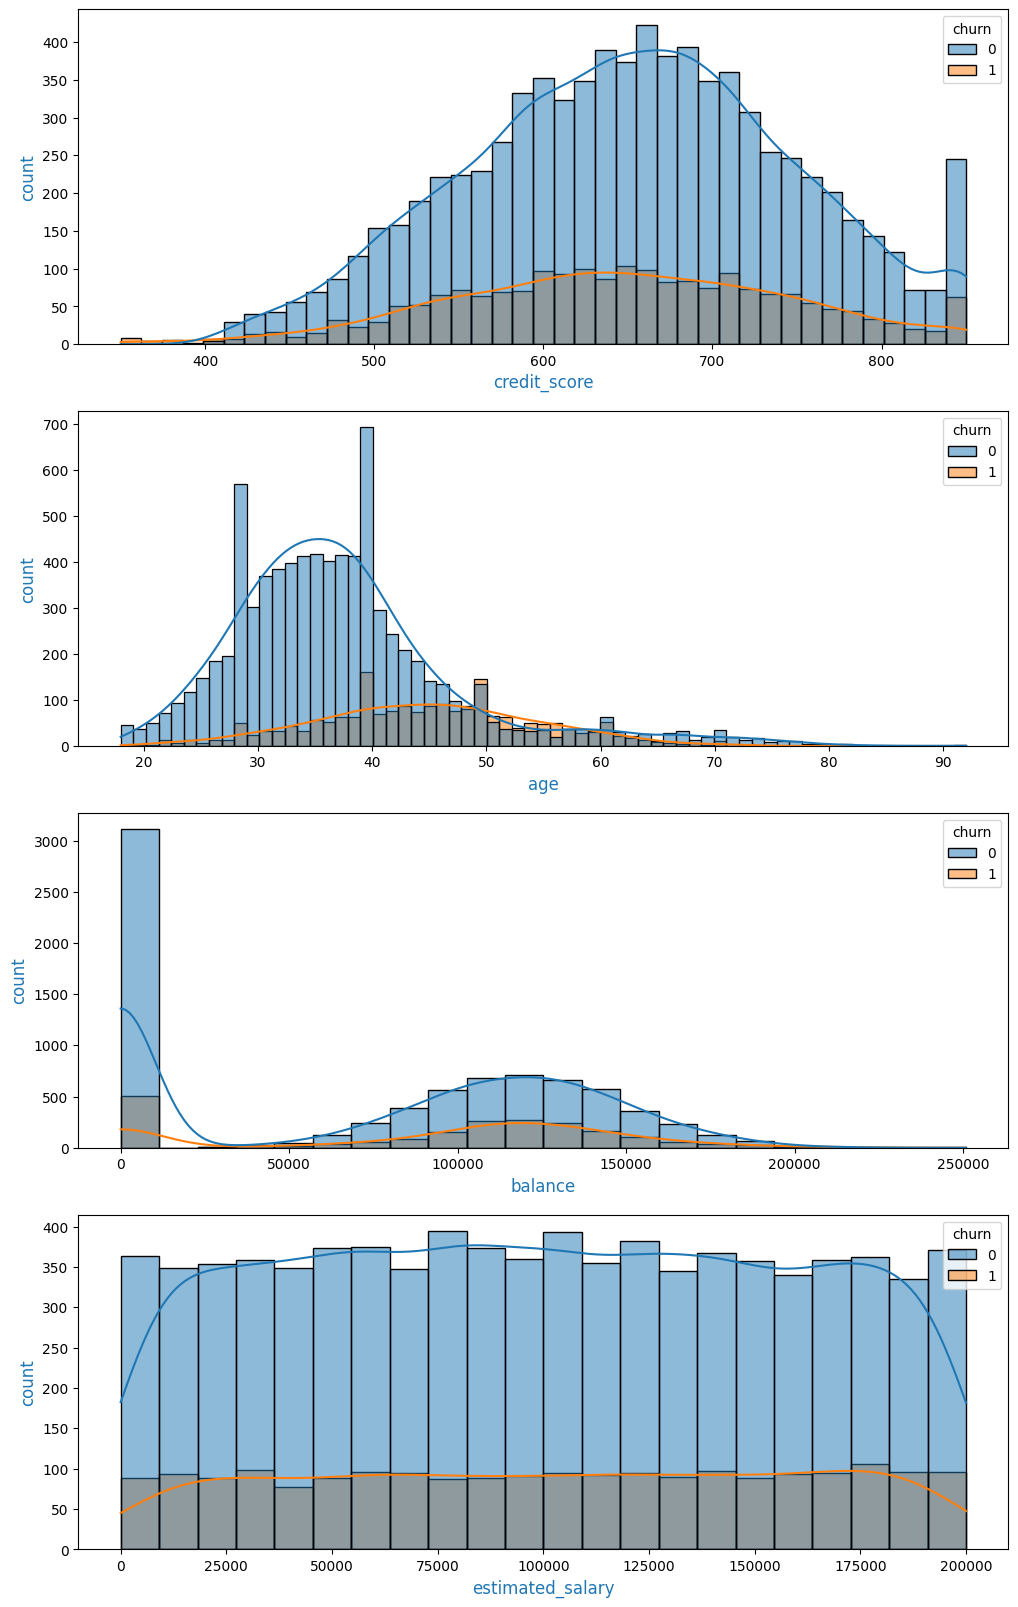

In [19]:
plt.figure(figsize=(12,20))

plt.subplot(4,1,1)
sns.histplot(df_cp, x='credit_score', hue='churn', kde=True, palette=[colors[0], colors[2]])
plt.xlabel('credit_score', fontsize=12, color=colors[0])
plt.ylabel('count', fontsize=12, color=colors[0])

plt.subplot(4,1,2)
sns.histplot(df_cp, x='age', hue='churn', kde=True, palette=[colors[0], colors[2]])
plt.xlabel('age', fontsize=12, color=colors[0])
plt.ylabel('count', fontsize=12, color=colors[0])

plt.subplot(4,1,3)
sns.histplot(df_cp, x='balance', hue='churn', kde=True, palette=[colors[0], colors[2]])
plt.xlabel('balance', fontsize=12, color=colors[0])
plt.ylabel('count', fontsize=12, color=colors[0])

plt.subplot(4,1,4)
sns.histplot(df_cp, x='estimated_salary', hue='churn', kde=True, palette=[colors[0], colors[2]])
plt.xlabel('estimated_salary', fontsize=12, color=colors[0])
plt.ylabel('count', fontsize=12, color=colors[0])

plt.show()

- Most people have a credit score between 600 and 700.
- Most non-churners are 30-40 years old, while most churners are 40-60 years old.
- There are many people who have no bank balance.

Analyzing the categorical features

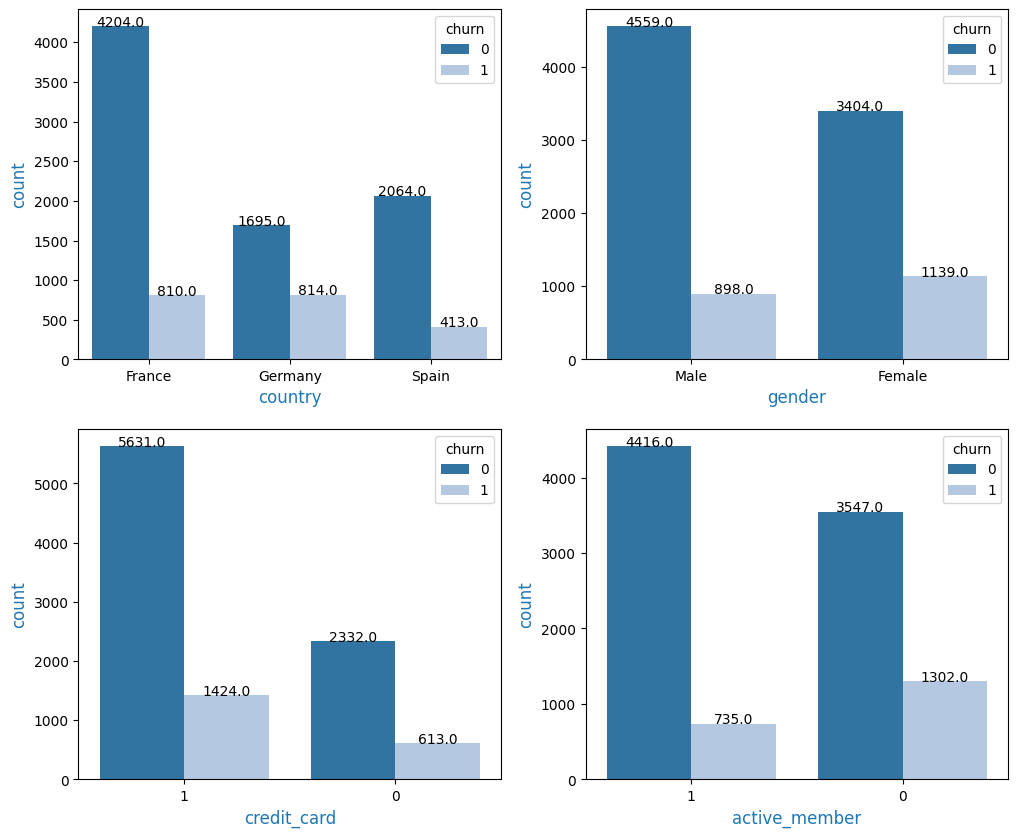

In [20]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
cplot = sns.countplot(data=df_cp, x='country', hue='churn', order=df_cp['country'].value_counts().index, palette=colors)
plt.xlabel('country', fontsize=12, color=colors[0])
plt.ylabel('count', fontsize=12, color=colors[0])
for x in cplot.patches:
  cplot.text (x.get_x() + x.get_width()  / 2, x.get_height()+ 0.75, x.get_height(), horizontalalignment='center', fontsize = 10)

plt.subplot(2,2,2)
cplot = sns.countplot(data=df_cp, x='gender', hue='churn', order=df_cp['gender'].value_counts().index, palette=colors)
plt.xlabel('gender', fontsize=12, color=colors[0])
plt.ylabel('count', fontsize=12, color=colors[0])
for x in cplot.patches:
  cplot.text (x.get_x() + x.get_width()  / 2, x.get_height()+ 0.75, x.get_height(), horizontalalignment='center', fontsize = 10)

plt.subplot(2,2,3)
cplot = sns.countplot(data=df_cp, x='credit_card', hue='churn', order=df_cp['credit_card'].value_counts().index, palette=colors)
plt.xlabel('credit_card', fontsize=12, color=colors[0])
plt.ylabel('count', fontsize=12, color=colors[0])
for x in cplot.patches:
  cplot.text (x.get_x() + x.get_width()  / 2, x.get_height()+ 0.75, x.get_height(), horizontalalignment='center', fontsize = 10)

plt.subplot(2,2,4)
cplot = sns.countplot(data=df_cp, x='active_member', hue='churn', order=df_cp['active_member'].value_counts().index, palette=colors)
plt.xlabel('active_member', fontsize=12, color=colors[0])
plt.ylabel('count', fontsize=12, color=colors[0])
for x in cplot.patches:
  cplot.text (x.get_x() + x.get_width()  / 2, x.get_height()+ 0.75, x.get_height(), horizontalalignment='center', fontsize = 10)

plt.show()

- Germany has the highest number of churners.
- Spain has relatively few churners.
- Female churners > Male churners.
- Most churners have credit cards but are not active members.

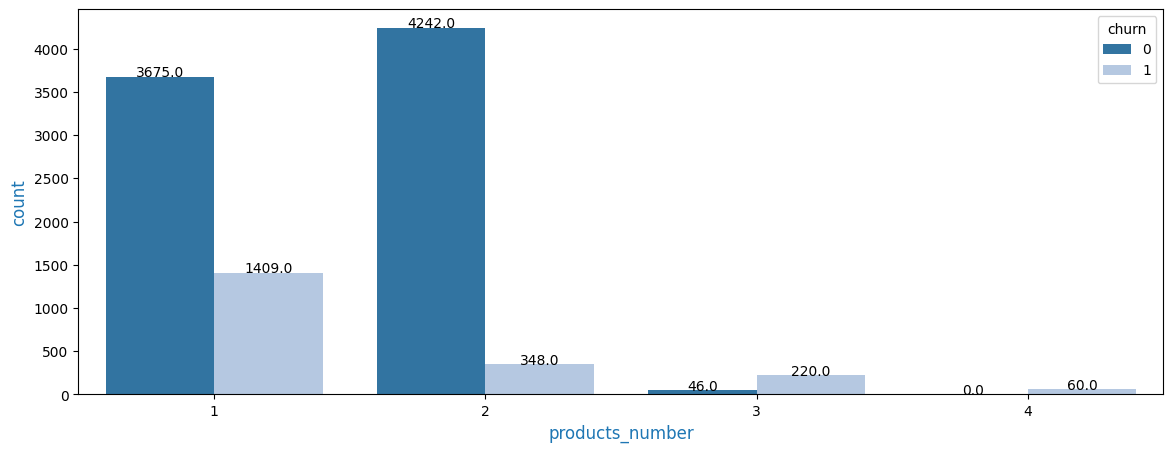

In [21]:
plt.figure(figsize=(14,5))

cplot = sns.countplot(data=df_cp, x='products_number', hue='churn', palette=colors)
plt.xlabel('products_number', fontsize=12, color=colors[0])
plt.ylabel('count', fontsize=12, color=colors[0])
for x in cplot.patches:
  cplot.text (x.get_x() + x.get_width()  / 2, x.get_height()+ 0.75, x.get_height(), horizontalalignment='center', fontsize = 10)

plt.show()

- Most customers have only 1 or 2 products.
- Most of the non-churners have 2 products.
- Most of the churners have 1 product.
- Customers having 3,4 products are mostly churners.

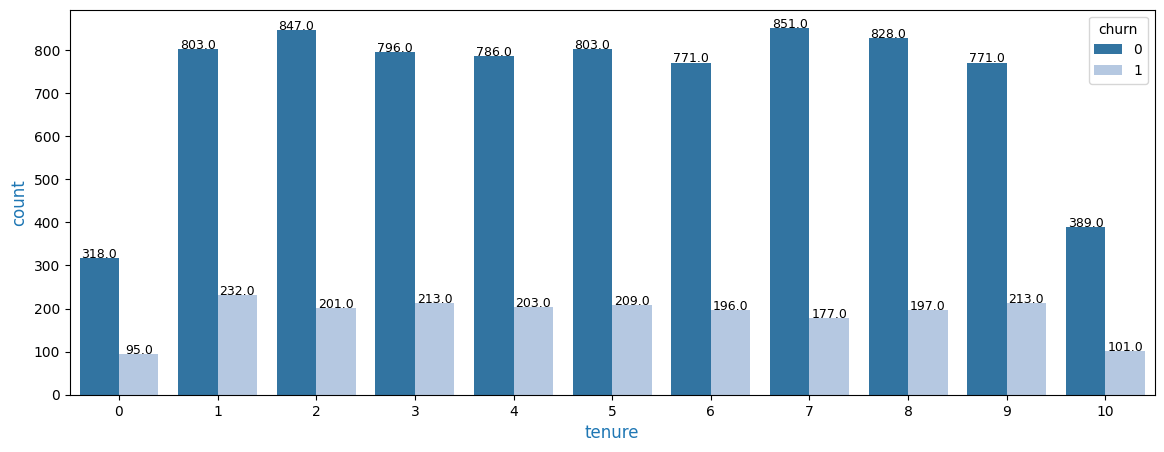

In [22]:
plt.figure(figsize=(14,5))

cplot = sns.countplot(data=df_cp, x='tenure', hue='churn', palette=colors)
plt.xlabel('tenure', fontsize=12, color=colors[0])
plt.ylabel('count', fontsize=12, color=colors[0])
for x in cplot.patches:
  cplot.text (x.get_x() + x.get_width()  / 2, x.get_height()+ 0.75, x.get_height(), horizontalalignment='center', fontsize = 9)

plt.show()

- Most churners have a tenure of 1 year.
- Only a few customers have a tenure of 0 or 10 years.

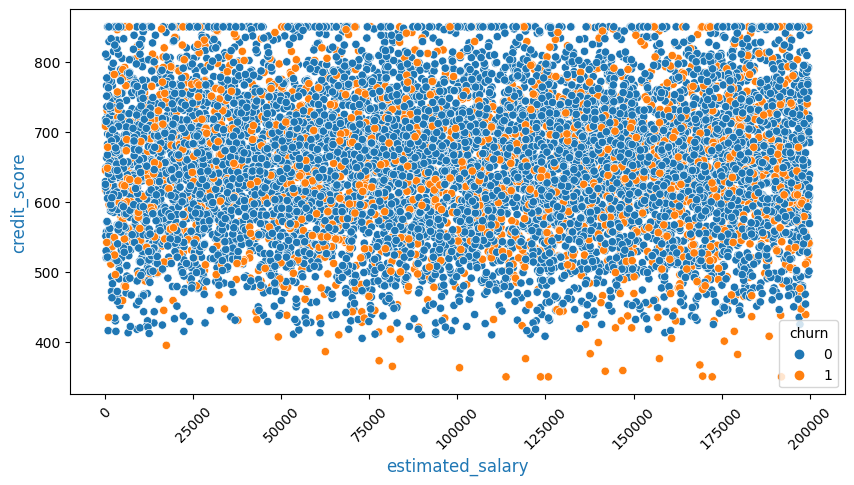

In [23]:
plt.figure(figsize=(10,5))

sns.scatterplot(data=df_cp, x='estimated_salary', y='credit_score', hue='churn', palette=[colors[0], colors[2]])
plt.xlabel('estimated_salary', fontsize=12, color=colors[0])
plt.ylabel('credit_score', fontsize=12, color=colors[0])
plt.xticks(rotation=45)

plt.show()

Customers with a credit score < 400 are mostly churners

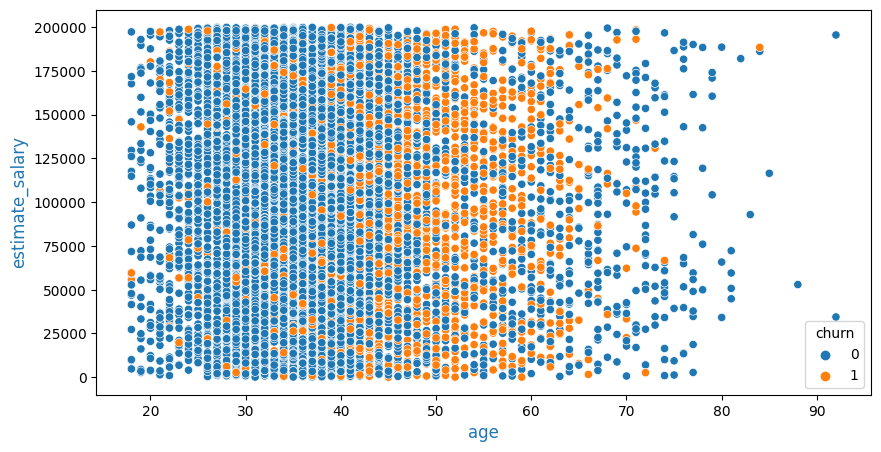

In [24]:
plt.figure(figsize=(10,5))

sns.scatterplot(data=df_cp, x='age', y='estimated_salary', hue='churn', palette=[colors[0], colors[2]])
plt.xlabel('age', fontsize=12, color=colors[0])
plt.ylabel('estimate_salary', fontsize=12, color=colors[0])

plt.show()

Most churners lie within the age group of 40-60 years

## Data pre-processing

In [25]:
dfEnc=df_cp.copy()

Encoding 'gender', 'country'

In [26]:
dfEnc["gender"] = LabelEncoder().fit_transform(dfEnc["gender"])
dfEnc["country"] = LabelEncoder().fit_transform(dfEnc["country"])

Separating dependent and independent variables

In [27]:
X=dfEnc.drop('churn',axis=1)
X.head().style.set_properties(**{"border" : "1px solid"})

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,619,0,0,42,2,0.000000,1,1,1,101348.880000
1,608,2,0,41,1,83807.860000,1,0,1,112542.580000
2,502,0,0,42,8,159660.800000,3,1,0,113931.570000
3,699,0,0,39,1,0.000000,2,0,0,93826.630000
4,850,2,0,43,2,125510.820000,1,1,1,79084.100000


In [28]:
Y=dfEnc['churn']
Y.head()

0    1
1    0
2    1
3    0
4    0
Name: churn, dtype: int64

Using SMOTE to handle data imbalance

In [29]:
X_bal,Y_bal=SMOTE().fit_resample(X,Y)

In [30]:
Y_bal.value_counts()

churn
1    7963
0    7963
Name: count, dtype: int64

Train-test split

In [31]:
X_train,X_test,Y_train,Y_test=train_test_split(X_bal,Y_bal,test_size=0.2,random_state=42)

In [32]:
print("X_bal shape : ", X_bal.shape)
print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("Y_bal shape : ", Y_bal.shape)
print("Y_train shape : ", Y_train.shape)
print("Y_test shape : ", Y_test.shape)

X_bal shape :  (15926, 10)
X_train shape :  (12740, 10)
X_test shape :  (3186, 10)
Y_bal shape :  (15926,)
Y_train shape :  (12740,)
Y_test shape :  (3186,)


## Model building

Building the classifier

In [33]:
rf = RandomForestClassifier(n_jobs=-1, verbose=2)

In [34]:
rf.fit(X_train, Y_train)

building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.3s


building tree 49 of 100building tree 50 of 100

building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


RandomForestClassifier(n_jobs=-1, verbose=2)

In [35]:
Y_pred = rf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Classification report

In [36]:
print(metrics.classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1633
           1       0.85      0.89      0.87      1553

    accuracy                           0.87      3186
   macro avg       0.87      0.87      0.87      3186
weighted avg       0.87      0.87      0.87      3186



Confusion matrix

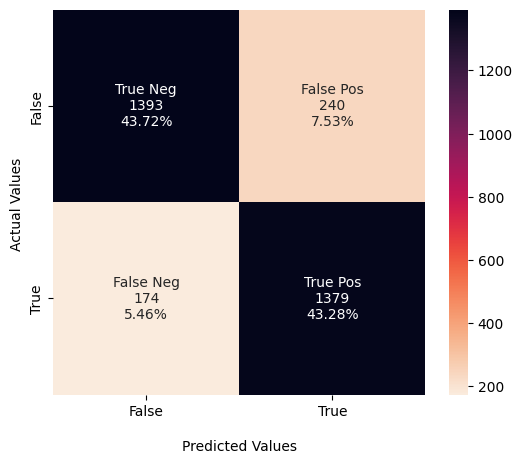

In [37]:
cf_matrix = metrics.confusion_matrix(Y_test, Y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(6,5))
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap=c_map)
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

ROC curve and AUC

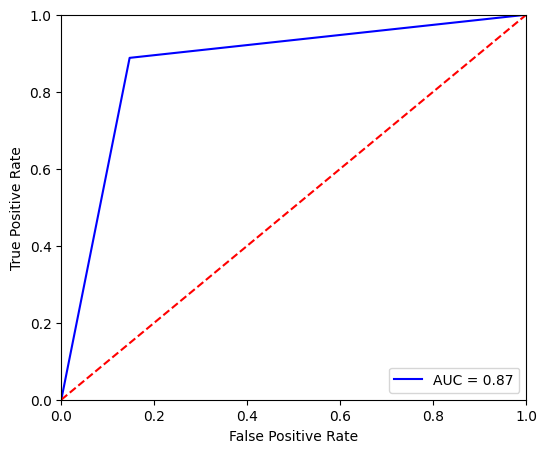

In [38]:
fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Predicting churn for a sample input

In [39]:
sample = [[400, 1, 0, 50, 3, 500.00, 1, 1, 0, 200000.00]]
sample_df = pd.DataFrame(sample, columns=['credit_score', 'country', 'gender', 'age', 'tenure', 'balance'	,'products_number' ,'credit_card',	'active_member'	,'estimated_salary'])
print("Sample input:- \n")
display(sample_df.style.set_properties(**{"border" : "1px solid"}))
print("\n\nPredicted value:- \n")
pred = rf.predict(sample_df)
if pred[0] == 1:
  print("Customer is likely to leave\n")
else:
  print("Customer is likely to stay\n")

Sample input:- 



,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,400,1,0,50,3,500.000000,1,1,0,200000.000000




Predicted value:- 

Customer is likely to leave



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Saving the model using 'pickle'

In [40]:
filename = 'final_model.sav'
pickle.dump(rf, open(filename, 'wb'))

Model has been saved